# Document Classification using Naive Bayes - Lab

## Introduction

In this lab, we'll make use of our newfound Bayesian knowledge to classify emails as spam or not spam from the [UCI Machine Learning Repository's Spambase Dataset](https://archive.ics.uci.edu/ml/datasets/spambase).  

## Objectives

You will be able to:
* Work with a real-world dataset from the UCI Machine Learning Repository
* Classify emails as spam or not spam by making use of Naive Bayesian Classification
* Evaluate the quality of our classifier by building a Confusion Matrix

## Let's get started!

Run the cell below to import everything we'll need for this lab.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
# Do not change the random seed, or else the tests will fail!
np.random.seed(0)
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import re


For this lab, we'll be working with the [Spambase Dataset](https://archive.ics.uci.edu/ml/datasets/spambase) from [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). 

This dataset contains emails that have already been vectorized, as well as summary statistics about each email that can also be useful in classification.  In this case, the Data Dictionary containing the names and descriptions of each column is stored in a separate file from the dataset itself.  For ease of use, we have included the `spambase.csv` file in this repo.  However, we have not included the Data Dictionary and column names.  

In the cell below, read in the data from `spambase.csv`, store it in a DataFrame, and print the head.  

**_HINT:_** By default, pandas will automatically assume that the first row contains metadata containing the column names. Since our dataset does not have a row of metadata, pandas will mistakenly assume the values for the first email are the column names for each column.  You can prevent this by setting the `header` parameter to `None`.

In [2]:
# Test 1: Do not change variable name!
df = pd.read_csv("spambase.csv", header=None)

As we can see, the dataset does not contain column names.  You will need to manually grab these from the [Dataset Description](https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names) and create an array containing the correct column names that we can set.  

Take a minute to visit the link above and get the names of each column.  There's no python magic needed here--you'll just need to copy and paste them over in the correct order as strings in a python array.  (It's not glamorous, but it's realistic.  This is a pretty common part of the Data Science Process.)

In the cell below, create the array of column names and then use this array to set the correct column names for the `df` object.  

**_NOTE:_** Be sure to read the Dataset Description/Documentation carefully.  Note that the last column of the dataset (we can call it `is_spam` is the last column of the actual dataset, although the data description has it at the top, not the bottom, of the list.  Make sure you get this column name in the right place, as it will be our target variable!

In [3]:
# Test 2: Do not chang variable name!
html_page = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names') 
soup = BeautifulSoup(html_page.content, 'html.parser')
lst = soup.prettify().split("\r\n")
a_copy = lst.copy()
for item in lst:
    if "continuous" not in item or item.startswith("|"):
        a_copy.remove(item)
    else:
        new_item = item.replace("continuous.", "")
        new_item = new_item.rstrip(": \n")
        a_copy.append(new_item)
        a_copy.remove(item)
a_copy.append("is_spam")
column_names = np.array(a_copy.copy())
len(column_names)
df.columns=column_names
print(df.head(), df.tail())

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail   ...     char_freq_;  char_freq_(  \
0             0.00            0.00   ...            0.00        0.0

## Cleaning and Exploring the Dataset

Now, in the cell below, use what you've learned to clean and explore the dataset.  Make sure you check for null values, and examine the descriptive statistics for the dataset.  

Try to create at least 1 visualization during this Exploratory Data Analysis (EDA) process. 

Use the cells below for this step. 

**_Remember_**, if you need to add more cells, you can always highlight a cell, press `esc` to enter command mode, and then press `a` to add a cell above the highlighted cell, or `b` to add a cell below the highlighted cell. 

In [4]:
df.isna().sum().unique()
# no null values

array([0])

In [5]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [6]:
df.corr()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
word_freq_make,1.000000,-0.016759,0.065627,0.013273,0.023119,0.059674,0.007669,-0.003950,0.106263,0.041198,...,-0.026505,-0.021196,-0.033301,0.058292,0.117419,-0.008844,0.044491,0.061382,0.089165,0.126208
word_freq_address,-0.016759,1.000000,-0.033526,-0.006923,-0.023760,-0.024840,0.003918,-0.016280,-0.003826,0.032962,...,-0.007282,-0.049837,-0.018527,-0.014461,-0.009605,0.001946,0.002083,0.000271,-0.022680,-0.030224
word_freq_all,0.065627,-0.033526,1.000000,-0.020246,0.077734,0.087564,0.036677,0.012003,0.093786,0.032075,...,-0.033213,-0.016495,-0.033120,0.108140,0.087618,-0.003336,0.097398,0.107463,0.070114,0.196988
word_freq_3d,0.013273,-0.006923,-0.020246,1.000000,0.003238,-0.010014,0.019784,0.010268,-0.002454,-0.004947,...,-0.000591,-0.012370,-0.007148,-0.003138,0.010862,-0.000298,0.005260,0.022081,0.021369,0.057371
word_freq_our,0.023119,-0.023760,0.077734,0.003238,1.000000,0.054054,0.147336,0.029598,0.020823,0.034495,...,-0.032759,-0.046361,-0.026390,0.025509,0.041582,0.002016,0.052662,0.052290,0.002492,0.241920
word_freq_over,0.059674,-0.024840,0.087564,-0.010014,0.054054,1.000000,0.061163,0.079561,0.117438,0.013897,...,-0.019119,-0.008705,-0.015133,0.065043,0.105692,0.019894,-0.010278,0.090172,0.082089,0.232604
word_freq_remove,0.007669,0.003918,0.036677,0.019784,0.147336,0.061163,1.000000,0.044545,0.050786,0.056809,...,-0.033089,-0.051885,-0.027653,0.053706,0.070127,0.046612,0.041565,0.059677,-0.008344,0.332117
word_freq_internet,-0.003950,-0.016280,0.012003,0.010268,0.029598,0.079561,0.044545,1.000000,0.105302,0.083129,...,-0.027432,-0.032494,-0.019548,0.031454,0.057910,-0.008012,0.011254,0.037575,0.040252,0.206808
word_freq_order,0.106263,-0.003826,0.093786,-0.002454,0.020823,0.117438,0.050786,0.105302,1.000000,0.130624,...,-0.014646,-0.031003,0.013601,0.043639,0.149365,-0.000522,0.111308,0.189247,0.248724,0.231551
word_freq_mail,0.041198,0.032962,0.032075,-0.004947,0.034495,0.013897,0.056809,0.083129,0.130624,1.000000,...,0.011945,0.003936,0.007357,0.036737,0.075786,0.044830,0.073677,0.103308,0.087273,0.138962


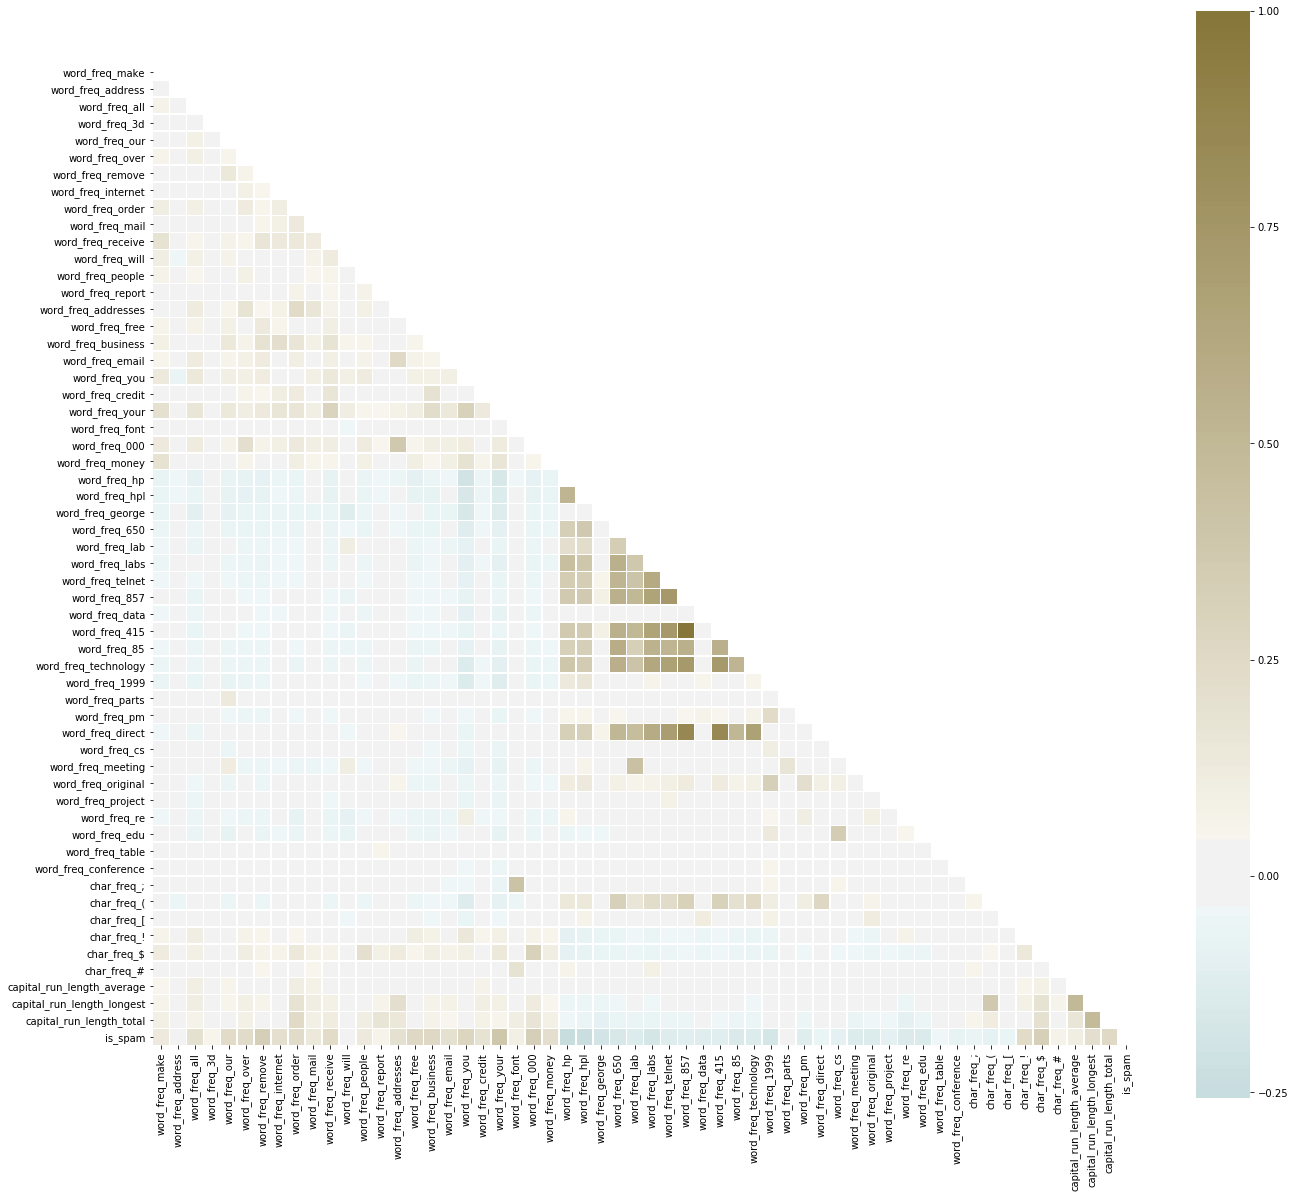

In [7]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(22,20))

cmap = sns.diverging_palette(200, 70, as_cmap=True)

sns.heatmap(df.corr(), mask=mask, cmap=cmap, center=0, 
            square=True, linewidths=.5)

## Analysis of Exploration

Did you notice anything interesting during your EDA? Briefly explain your approach and your findings below this line:
________________________________________________________________________________________________________________________________




## Creating Training and Testing Sets

Since we are using Naive Bayes for classification, we'll need to treat this like any other machine learning problem and create separate **_training sets_** and **_testing sets_** for **_holdout validation_**.  Otherwise, if we just trust the classifier's performance on the training set, we won't know for sure if the classifier has learned to detect spam emails in the real world, or just from this particular dataset.  

In the cell below:

* Store the target column in a separate variable and then remove it from the dataset. 
* Create training and testing sets using the [appropriate method](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from `sklearn`.  

**_HINT:_** We want to make sure that the training and testing samples get same distribution of spam/not spam emails.  Otherwise, our model may get a training set that doesn't contain enough of one class to learn how to tell it apart from the other.  In order to deal with this problem, we can pass in the variable containing our labels to the `stratify` parameter.  For more information, see the documentation in the link above.  

In [8]:
# Test 3: Do not change variable names!
target = df.is_spam
clean_df = df.drop('is_spam', axis=1 )


# Test 4: Do not change variable names!
X_train, X_test, y_train, y_test = train_test_split(clean_df, target, test_size=.20)

## Fitting our Classifier

Now that we have split our data into appropriate sets, we need to fit our classifier before we can make predictions and check our model's performance.

Recall what you learned about the 3 different types of Naive Bayesian Classifiers provided by `sklearn`.  Given the distribution of our data, explain why each of the following classifier types is or isn't appropriate for this problem.

**_GaussianNB:_**  

**_BernoulliNB:_**   

**_MultinomialNB:_** 

In the cell below, create the appropriate classifier type and then `fit()` it to the appropriate training data/labels.

In [11]:
clf = GaussianNB()
clf.fit(X_train)


TypeError: fit() missing 1 required positional argument: 'y'

## Making Predictions

Now that we have a fitted model, we can make predictions on our testing data.  

In the cell below, use the appropriate method to make predictions on the data contained inside `X_test`.

In [ ]:
preds = None

## Checking Model Performance

Now that we have predictions, we can check the accuracy of our model's performance.  In order to do this, we'll use two different metrics: `accuracy_score` and `f1_score`.  For classification, accuracy is defined as the number of correct predictions (**_True Positives_** and **_True Negatives_**) divided by the total number of predictions.  

**_F1 Score_** is the harmonic mean of precision and recall. This tells us the accuracy, but penalizes the classifier heavily if it favors either **_Precision_** (Spam emails correctly identified, divided by all emails predicted to be spam) or **_Recall_** (the percentage of spam emails successfully caught, out of all spam emails) too much.  Don't worry if you aren't yet familiar with these terms--we'll cover these concepts in depth in later lessons!

In the cell below, use the appropriate helper functions from sklearn to get the accuracy and f1 scores for our model.  

In [ ]:
# Test 5: Do not change variable name!
accuracy = None

# Test 6: Do not change variable name!
f1 = None

print("Accuracy Score for model: {:.4}%".format(accuracy * 100))
print("F1 Score for model: {:.4}%".format(f1 * 100))

## Digging Deeper: Using a Confusion Matrix

Our model does pretty well, with ~81% accuracy.  However, we don't know _how_ it's failing on the 19% it got wrong.  In order to figure this out, we'll build a **_Confusion Matrix_**.

For every prediction our model makes, there are four possible outcomes:

**_True Positive:_** Our model predicted that the email was spam, and it was actually spam. 

**_True Negative:_** Our model predicted that the email was not spam, and it wasn't spam. 

**_False Positive:_** Our model predicted that the email was spam, but it wasn't.

**_False Negative:_** Our model predicted that the email wasn't spam, but it was.  


### Question:

Which type of misclassification is preferable to the other--False Positives or False Negatives?  In this given problem, which one is preferable to the other? Explain your answer below this line:
________________________________________________________________________________________________________________________________




### Building our Confusion Matrix

In the cell below, complete the `confusion_matrix` function.  This function should take in two parameters, `predictions` and `labels`, and return a dictionary counts for `'TP', 'TN', 'FP',` and `'FN'` (True Positive, True Negative, False Positive, and False Negative, respectively).  

Once you have completed this function, use it to create Confusion Matrices for both the training and testing sets, and complete the tables in the following markdown cell.

**_HINT:_** Your labels are currently stored in a pandas series.  To make things easier, consider converting this series to a regular old python list!

In [ ]:
# Test 7: Do not change function signature!
def confusion_matrix(predictions, labels):
    pass

# Test 8: Do not change variable names!
training_preds = None

# Test 9: Do not change variable names!
training_cm = {"TP": 1310, "TN": 1524, "FP": 567, "FN": 49}

# Test 10: Do not change variable names!
testing_cm = None

print("Training Confusion Matrix: {}".format(training_cm))
print("Testing Confusion Matrix: {}".format(testing_cm))

## Intepreting Our Results

Complete the tables below, and then use them to answer the following questions.


|  Training Results  | **Is Spam** | **Is Email** |
|:---------------:|:-------:|:--------:|
|  **Predicted Spam** |         |          |
| **Predicted Email** |         |          |
<br>

|  Testing Results  | **Is Spam** | **Is Email** |
|:---------------:|:-------:|:--------:|
|  **Predicted Spam** |         |          |
| **Predicted Email** |         |          |


How many emails are getting caught up in the spam filter? How many spam emails are getting through the filter?  Is this a model you would recommend shipping to production? Why or why not?
________________________________________________________________________________________________________________________________




Don't worry about tuning the model for now--that's a lengthy process, and we'll cover it in depth in later labs.  For now, congratulations--you just built a working spam filter using Naive Bayesian Classification!


## Summary

In this lab, we:
* Worked with a real-world dataset from the UCI Machine Learning Repository.
* Classified emails as spam or not spam by with a Naive Bayesian Classifier. 
* Built a Confusion Matrix to evaluate the performance of our classifier.   
